### Training

In [36]:
import importlib

import utils.sound_utils as su
import utils.train_utils as tu
import utils.filter_utils as filter
import utils.plot_utils as pu

from sklearn import tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import wget

import os
import sys
import importlib
import pickle
import numpy as np
import pandas as pd

importlib.reload(su)
importlib.reload(tu)
importlib.reload(pu)
importlib.reload(filter)


<module 'utils.filter_utils' from 'c:\\Users\\gonza\\OneDrive\\Documentos\\Gonzalo\\Especializacion\\inteligencia_embebida\\esp32_loopback\\python\\utils\\filter_utils.py'>

In [37]:

#wget.download('https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip')
#wget.download('https://www.dropbox.com/s/qoyduoa5prupyzr/test_files.csv')
#wget.download('https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv')

In [38]:
labels = {
    0: "bite",
    1: "chew",
    2: "chew_byte"
}

In [39]:
train_labels = pd.read_csv("data/train_labels.csv")
test_labels = pd.read_csv("data/test_files.csv")

In [40]:
train_labels.head()

,filename,pasture,height,label
0,4,alfalfa,tall,2
1,9,alfalfa,tall,2
2,10,alfalfa,tall,1
3,11,alfalfa,tall,2
4,13,alfalfa,tall,2


In [41]:
test_labels.head()

,filename
0,1
1,2
2,3
3,5
4,6


In [42]:
dataset = tu.upload_dataset("data/audios")

In [43]:
len(dataset)

3083

In [57]:
sample_rate = 22050
f_cutoff = 5
f_norm = f_cutoff / sample_rate
window_size = (0.196202 + f_norm ** 2) ** 0.5 / f_norm

filter_ma = filter.MovingAverage(window_size=int(window_size))
filtered_data = []


for _, audio in dataset:
    filtered_aux = []
    for value in audio:
        absolute = abs(value) if abs(value) >= 0 else np.iinfo(value.dtype).max
        filtered_aux.append(filter_ma.calculate_ma(absolute))
    filtered_data.append(filtered_aux)
    
    

In [46]:
with open('data/filtered_data.pkl', 'wb') as f:
    pickle.dump(filtered_data, f)

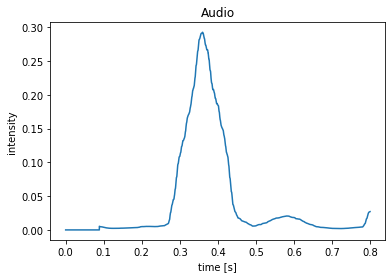

In [58]:
from utils.sound_utils import plot_audio

plot_audio(filtered_data[0], sample_rate)

In [70]:
noise_gate_data = []
noise_gate = su.NoiseGate(open_threshold=0.1, close_threshold=0.1, hold=0)
for data in filtered_data:
    filtered_data_list, init, end = noise_gate.split(data, sample_rate)
    if len(filtered_data_list) == 1:
        noise_gate_data.append(filtered_data_list[0])
    elif len(filtered_data_list) > 0:
        noise_gate_data.append(filtered_data_list[0])
    else:
        noise_gate_data.append([])

In [ ]:
noise_gate_data[0]

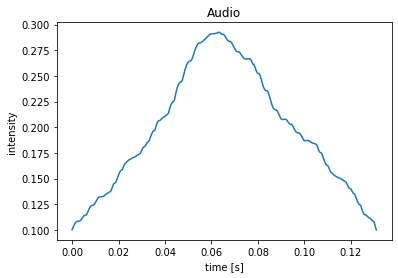

In [71]:
plot_audio(noise_gate_data[0], sample_rate)

In [72]:
extracted_data = []
for data in noise_gate_data:
    extractor = su.FeatureExtractor(data, sample_rate)
    extracted_data.append(extractor.extract_features())

In [73]:
with open('data/extracted_data.pkl', 'wb') as f:
    pickle.dump(extracted_data, f)

In [74]:
file = open('data/extracted_data.pkl', 'rb')
extracted_data = pickle.load(file)

In [75]:
extracted_data

[[0.1310657596371882,
  0.2925075840371226,
  59,
  0.47545765203494544,
  0.05790615121587316],
 [0.13673469387755102,
  0.21795205299950884,
  95,
  0.5855914950751079,
  0.03611986664978692],
 [0.0727437641723356,
  0.13936246880584038,
  45,
  0.7169725897279943,
  0.011442871754889082],
 [0.10535147392290249,
  0.21932469836094284,
  67,
  0.5470451455781643,
  0.03688397171126909],
 [0.0, 0, 0, 0, 0.0],
 [0.10879818594104308,
  0.22589988231856403,
  65,
  0.5718180936553998,
  0.03637094265783758],
 [0.08662131519274377,
  0.1586807009306234,
  69,
  0.5868457409326597,
  0.016575948459270212],
 [0.08598639455782313,
  0.17278226812406003,
  61,
  0.533837666317665,
  0.02021280750719314],
 [0.07546485260770976,
  0.13802471736742736,
  63,
  0.4881182812641785,
  0.010576384881162715],
 [0.0, 0, 0, 0, 0.0],
 [0.12077097505668934,
  0.24388534785108099,
  107,
  0.49215520280731617,
  0.044301757697725305],
 [0.07351473922902495,
  0.1369525066517619,
  49,
  0.33664829694374204

In [76]:
extracted_data[0]

[0.1310657596371882,
 0.2925075840371226,
 59,
 0.47545765203494544,
 0.05790615121587316]

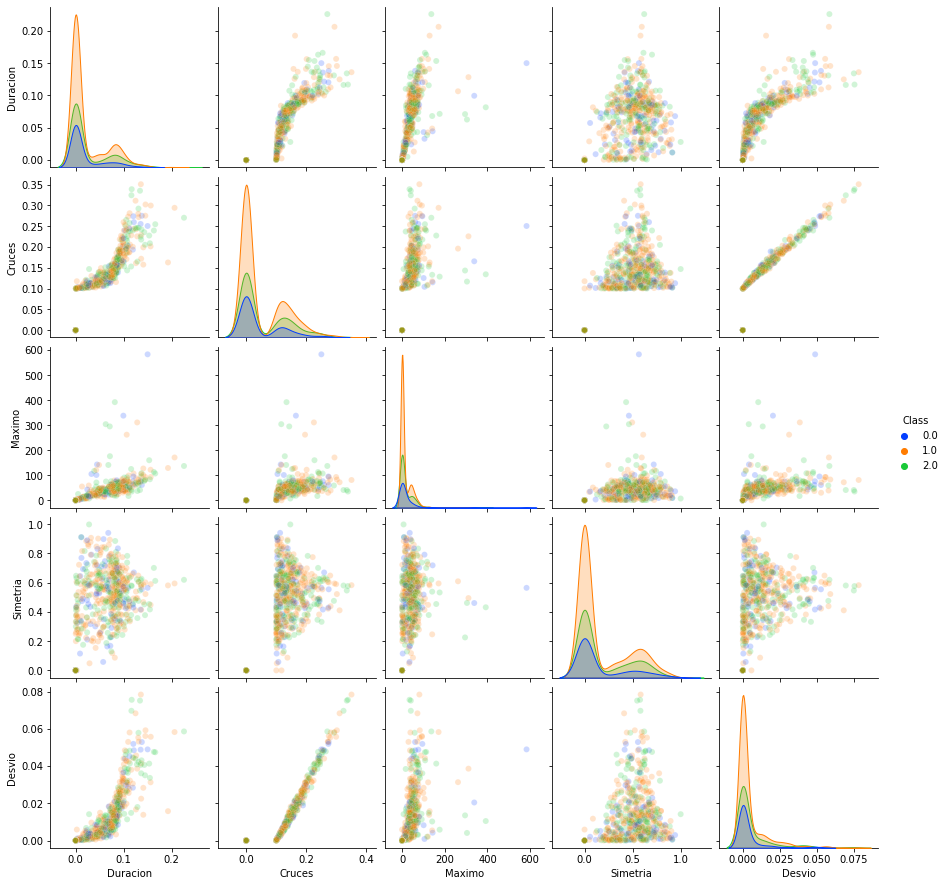

In [77]:
import pandas.testing as tm
import seaborn

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]

df_train = pd.DataFrame(extracted_data, columns=colnames)
df_train.insert(len(df_train.columns), "Class", train_labels["label"])

seaborn.pairplot(df_train,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright")

### Training

In [78]:
X_data = np.array(extracted_data)
X_data.size
len(extracted_data)

3083

In [79]:
from itertools import count


X_data = extracted_data
y_data = train_labels.label.to_list()

X_train = []
y_train = []

test_indexes = test_labels.filename.to_list()
counter = 0
for i, value in enumerate(extracted_data):
    if value == []:
        continue
    if i not in test_indexes:
        X_train.append(value)
        y_train.append(str(y_data[counter]))
        counter += 1


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.33,
                                                    random_state=42)

In [81]:
models = {}
params = {'criterion': ['gini','entropy'], 'splitter': ['best','random'], 'max_depth': [2, 3, 4]}
model = tu.get_best_model(DecisionTreeClassifier, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), params, models, "model_dt") 


{'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}
Grid search time: 0.3271674000425264 s
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        98
           1    0.61538   0.84706   0.71287       255
           2    0.54839   0.55556   0.55195       153

    accuracy                        0.59486       506
   macro avg    0.38792   0.46754   0.42161       506
weighted avg    0.47594   0.59486   0.52615       506

Training time: 0.0018894000095315278 s


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

[Text(0.5, 0.875, 'Duracion <= 0.001\ngini = 0.582\nsamples = 1026\nvalue = [157, 572, 297]\nclass = chew'),
 Text(0.3, 0.625, 'Simetria <= 0.1\ngini = 0.457\nsamples = 685\nvalue = [87, 484, 114]\nclass = chew'),
 Text(0.2, 0.375, 'Desvio <= 0.0\ngini = 0.458\nsamples = 683\nvalue = [87, 482, 114]\nclass = chew'),
 Text(0.1, 0.125, 'gini = 0.457\nsamples = 682\nvalue = [86, 482, 114]\nclass = chew'),
 Text(0.3, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = bite'),
 Text(0.4, 0.375, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]\nclass = chew'),
 Text(0.7, 0.625, 'Duracion <= 0.001\ngini = 0.603\nsamples = 341\nvalue = [70, 88, 183]\nclass = chew_bite'),
 Text(0.6, 0.375, 'gini = 0.0\nsamples = 8\nvalue = [0, 0, 8]\nclass = chew_bite'),
 Text(0.8, 0.375, 'Maximo <= 45.5\ngini = 0.61\nsamples = 333\nvalue = [70, 88, 175]\nclass = chew_bite'),
 Text(0.7, 0.125, 'gini = 0.649\nsamples = 151\nvalue = [39, 46, 66]\nclass = chew_bite'),
 Text(0.9, 0.125, 'gini = 0.559\nsamples = 1

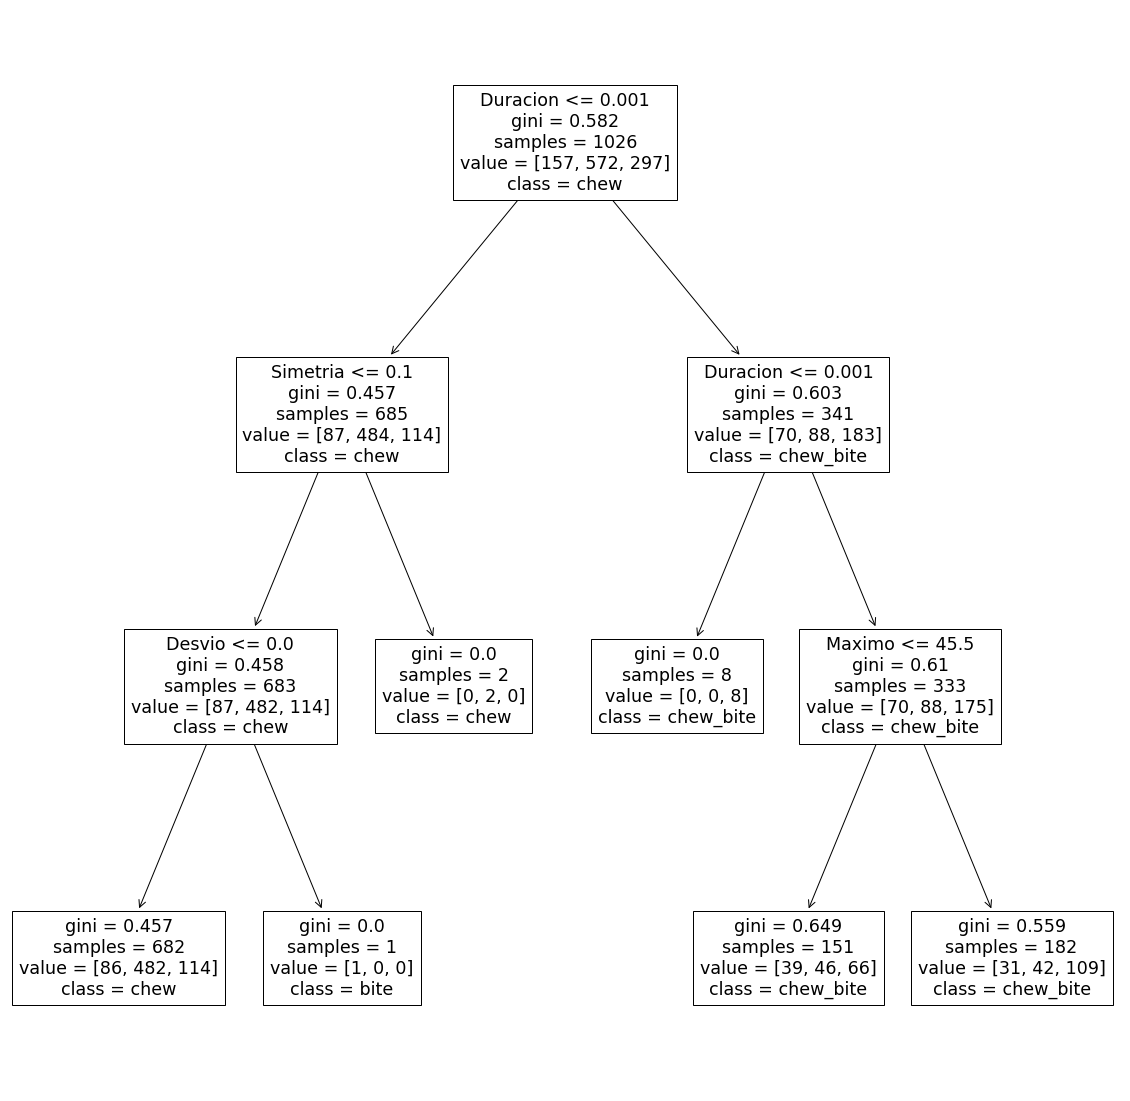

In [82]:
from turtle import width
import matplotlib.pyplot as plt
from numpy import size

labels = {
    0: "bite",
    1: "chew",
    2: "chew_byte"
}

plt.figure(figsize=(20, 20))
tree.plot_tree(model.model, feature_names=["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"], class_names=["bite", "chew", "chew_bite"])


In [83]:
plt.savefig('tree.png', format='png', bbox_inches = "tight", dpi=200)

<Figure size 432x288 with 0 Axes>